# Interpretable Machine Learning with Python
## **Exercise**: _Assessing Fairness of COMPAS Recidivism Risk Assessments_
### Workshop for Open Data Science Conference (ODSC) West — scheduled for October 30th, 2020 4:00 PM PDT
### by Serg Masís ([LinkedIn](https://www.linkedin.com/in/smasis/), [Twitter](https://twitter.com/smasis), [Serg.ai](https://www.serg.ai/), [Github](https://www.serg.ai/)) 

This notebook will walk through:

- Understanding fairness with confusion matrices.
- Training a proxy [CatBoost](https://catboost.ai/) model to attempt to understand the behavior of another model.
- Leveraging **global interpretation methods** [Feature Importance](https://catboost.ai/docs/concepts/fstr.html), [SHAP](https://shap.readthedocs.io/en/latest/examples.html#tree-explainer), and [Partial Dependence Plots](https://pdpbox.readthedocs.io/en/latest/) to understand what features impact the model and how.
- Exploring individual predictions with **local interpretation methods** [LIME](https://lime-ml.readthedocs.io/en/latest/lime.html#module-lime.lime_tabular), [Anchors](https://docs.seldon.io/projects/alibi/en/stable/methods/Anchors.html) and Counterfactuals with [What-If-Tool](https://pair-code.github.io/what-if-tool/).
- Tuning **dataset for increased interpretability and fairness** with feature engineering and balancing on protected features using [XAI](https://ethicalml.github.io/xai/index.html#balance-the-class-using-upsampling-and-or-downsampling).
- Training a Catboost **model with fairness in mind** using [monotonic constraints and cost-sensitive learning](https://catboost.ai/docs/concepts/python-reference_parameters-list.html#python-reference_parameters-list).
- Evaluating fairness of the monotonic model using [XAI](https://ethicalml.github.io/xai/index.html#model-evaluation).

For further background on Risk Recidivisim Assessments for COMPAS dataset:

- Angwin, J., Larson, J., Mattu, S., & Kirchner, L. (2016). Machine Bias. There is software that is
used across the county to predict future criminals. And it is biased against blacks. Propublica. [Article](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing) | [Code Explanation](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) | [Code](https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb)

The dataset we will use has already been filtered as performed by ProPublica, and unnecessary columns removed, such as those that reveal the defendants' identities. The original dataset can be  [found here](https://www.kaggle.com/danofer/compass?select=cox-violent-parsed_filt.csv).

## 1) Install Libraries
#### _(if not installed already)_

In [ ]:
!pip install --upgrade --quiet catboost shap PDPbox alibi lime witwidget xai

## 2) Load Libraries

In [1]:
#DATA WRANGLING
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#MODELING
from catboost import CatBoostClassifier, Pool, datasets

#VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

#FAIRNESS
import xai

#INTERPRETATION
from sklearn import metrics
import shap
from pdpbox import pdp
import lime
from alibi.explainers import AnchorTabular
import witwidget
from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

## 3) Data Understanding

### 3.1) Load Dataset

In [2]:
recidivism_df = pd.read_csv('https://raw.githubusercontent.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/master/datasets/recidivism-risk_odsc.csv')

### 3.2) Verify Dataset

Should have 14,788 records and 10 columns. None of the columns have nulls, and there are three categorical (`object`) columns.

In [3]:
recidivism_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14788 entries, 0 to 14787
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sex              14788 non-null  object
 1   age              14788 non-null  int64 
 2   race             14788 non-null  object
 3   juv_fel_count    14788 non-null  int64 
 4   juv_misd_count   14788 non-null  int64 
 5   juv_other_count  14788 non-null  int64 
 6   priors_count     14788 non-null  int64 
 7   c_charge_degree  14788 non-null  object
 8   compas_score     14788 non-null  int64 
 9   did_recid        14788 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 1.1+ MB


We can also gain an understanding of our data by taking a peek into first few records with `head`.

In [4]:
recidivism_df.head(10)

sex  age              race  juv_fel_count  juv_misd_count  \
0  Male   69             Other              0               0   
1  Male   69             Other              0               0   
2  Male   34  African-American              0               0   
3  Male   24  African-American              0               0   
4  Male   24  African-American              0               0   
5  Male   24  African-American              0               0   
6  Male   24  African-American              0               0   
7  Male   24  African-American              0               0   
8  Male   44             Other              0               0   
9  Male   41         Caucasian              0               0   

   juv_other_count  priors_count c_charge_degree  compas_score  did_recid  
0                0             0            (F3)             0          0  
1                0             0            (F3)             0          0  
2                0             0            (F3)             0          1  
3                1             4            (F3)             0          1  
4                1             4            (F3)             0          1  
5                1             4            (F3)             0          1  
6                1             4            (F3)             0          1  
7                1             4            (F3)             0          1  
8                0             0            (M1)             0          0  
9                0            14            (F3)             1          1

### 3.3) Examining Predictive Bias with Confusion Matrices

#### 3.3.1) Predictive Accuracy for COMPAS Model

Compare the ground truth of whether defendents did recidivate (`did_recid`) versus the prediction for medium/high risk of recidivisim (`compas_score`). 

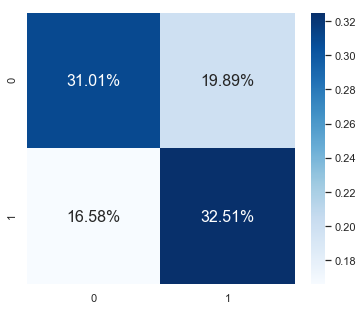

In [706]:
#Create confusion matrix.
conf_matrix = metrics.confusion_matrix(recidivism_df.did_recid,\
                                     recidivism_df.compas_score)

#Plot the confusion matrix with percetage formatting.
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot=True,\
            fmt='.2%', cmap='Blues', annot_kws={'size':16})
plt.show()

COMPAS model's predictive performance is not very good, specially if we assume that criminal justice decision-makers are taking medium or high-risk assessments at face value.It also tells false positives and negatives occur at a similar rate. Nevertheless, ***simple visualizations like the confusion matrix above obscure predictive disparities between subgroups of a population***.

#### 3.3.2) Comparing Predictive Accuracy Across Demographic Groups for COMPAS Model

We can quickly compare disparities between two subgroups that historically have been treated differently by the U.S. Criminal Justice System:

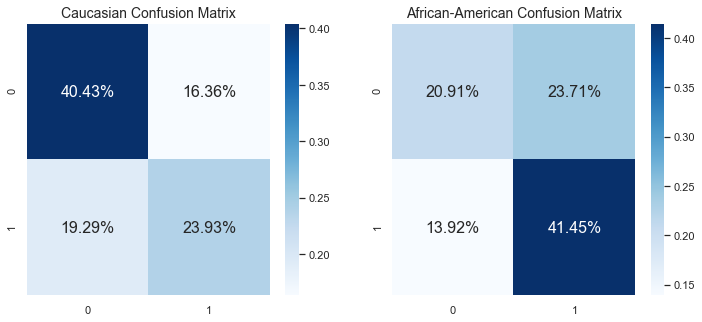

	African-American FPR:	53.1%
	Caucasian FPR:		28.8%
	Ratio FPRs:		1.84 x


In [432]:
def compare_confusion_matrices(y_true_1, y_pred_1, y_true_2, y_pred_2, group_1, group_2, plot=True):
    """Compare two confusion matrices and display FPR ratio metrics. 
    Return FPR ratio between matrices.
    
    Keyword arguments:
    y_true_1 -- ground truth values for first confusion matrix (pandas series or 1D array)
    y_pred_1 -- predictions for first confusion matrix  (pandas series or 1D array)
    y_true_2 -- ground truth values for second confusion matrix (pandas series or 1D array)
    y_pred_2 -- predictions for second confusion matrix  (pandas series or 1D array)
    group_1 -- name of group represented by first matrix (string)
    group_2 -- name of group represented by second matrix (string)
    plot -- whether to plot the confusion matrices or not (boolean)
    """
    
    #Create confusion matrices for two different groups.
    conf_matrix_1 = metrics.confusion_matrix(y_true_1, y_pred_1)
    conf_matrix_2 = metrics.confusion_matrix(y_true_2, y_pred_2)

    #Plot both confusion matrices side-by-side.
    if plot:
        fig, ax = plt.subplots(1,2,figsize=(12,5))
        sns.heatmap(conf_matrix_1/np.sum(conf_matrix_1), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[0])
        ax[0].set_title(group_1 + ' Confusion Matrix', fontsize=14)
        sns.heatmap(conf_matrix_2/np.sum(conf_matrix_2), annot=True,\
                    fmt='.2%', cmap='Blues', annot_kws={'size':16}, ax=ax[1])
        ax[1].set_title(group_2 + ' Confusion Matrix', fontsize=14)
        plt.show()

    #Calculate False Positive Rates (FPR) for each Group.
    tn, fp, _, _ = conf_matrix_1.ravel()
    fpr_1 = fp/(fp+tn)
    tn, fp, _, _ = conf_matrix_2.ravel()
    fpr_2 = fp/(fp+tn)

    #Print the FPRs and the ratio between them.
    if fpr_2 > fpr_1:
        print("\t" + group_2 + " FPR:\t%.1f%%" % (fpr_2*100))
        print("\t" + group_1 + " FPR:\t\t%.1f%%" % (fpr_1*100))
        print("\tRatio FPRs:\t\t%.2f x" % (fpr_2/fpr_1))
        return (fpr_2/fpr_1)
    else:
        print("\t" + group_1 + " FPR:\t%.1f%%" % (fpr_1*100))
        print("\t" + group_2 + " FPR:\t\t%.1f%%" % (fpr_2*100))
        print("\tRatio FPRs:\t\t%.2f x" % (fpr_1/fpr_2))
        return (fpr_1/fpr_2)

#Use the function above to compare both groups.
_ = compare_confusion_matrices(recidivism_df[recidivism_df.race == 'Caucasian'].did_recid,\
                               recidivism_df[recidivism_df.race == 'Caucasian'].compas_score,\
                               recidivism_df[recidivism_df.race == 'African-American'].did_recid,\
                               recidivism_df[recidivism_df.race == 'African-American'].compas_score,\
                               'Caucasian', 'African-American')

There are many disparities between both confusion matrices but ***unfairness relates more to False Positives (top right quadrant) than False Negatives (bottom left quadrant)***. 

If we wanted to convey the level of unfairness succinctly as a single metric, we could do so with _False Positive Rates_ which is the ratio between false positives over all those those that were negative (according to ground truth). African-American's are ***84% more likely to be falsely predicted to be of risk*** than Caucasians. 

## 4) Data Preparation

### 4.1) Encode Categorical Features

**Don't modify original dataset but make a copy**

In [8]:
recidivism2_df = recidivism_df.copy()

**Encode `sex` and `race`**

In [9]:
#One hot encode `sex` and `race` columns.
recidivism2_df = pd.get_dummies(recidivism2_df, columns=['sex', 'race'])

**How about `c_charge_degree`**

In [10]:
#List count for each category in `c_charge_degree` in descending order.
recidivism2_df.c_charge_degree.value_counts()

(F3)     8812
(M1)     3339
(F2)     1208
(M2)      991
(F1)      183
(F7)      123
(MO3)     103
(NI0)       8
(F5)        8
(CO3)       6
(F6)        5
(X)         1
(TCX)       1
Name: c_charge_degree, dtype: int64

There are many categories in `c_charge_degree` that have less than 100 defendants. The following code will bucket those categories as "Other":

In [11]:
def make_dummies_with_limits(df, colname, min_recs=0.005,\
                             max_dummies=20, defcatname='Other',\
                             nospacechr='_'):
    """Creates dummies for dataframe categorical column but buckets less represented categories.
    
    Keyword arguments:
    df -- dataframe
    colname -- name of the column (string)
    min_recs -- the threshold to be used to determine lesser categories (float or int)
                [< 1 is a percentage, otherwise a fixed amount]
    max_dummies -- maximum amount of dummies to create (int)
    defcatname -- category name to use for bucketing (string)
    nospacechr -- replace spaces in categories by this character (string)
    """
    
    if min_recs < 1:
        min_recs = df.shape[0]*min_recs
    topvals_df = df.groupby(colname).size().reset_index(name="counts").\
                    sort_values(by="counts", ascending=False).reset_index()
    other_l = topvals_df[(topvals_df.index > max_dummies) |\
                         (topvals_df.counts < min_recs)][colname].to_list()
    if len(other_l):
        df.loc[df[colname].isin(other_l), colname] = defcatname
    if len(nospacechr):
        df[colname] = df[colname].str.replace(' ',\
                                                  nospacechr, regex=False)
    return pd.get_dummies(df, prefix=[colname], columns=[colname])

#Leverage the above function to create dummies for major c_charge_degree categores 
# (bucket smaller ones in "Other").
recidivism2_df = make_dummies_with_limits(recidivism2_df, 'c_charge_degree')

### 4.2) Train/Test Split

In [13]:
#For reproducibility, it's imperative to consistently use a seed number and set it to NumPy, 
# tensorflow or in whatever place a stochastic process exists and allows for it to be set.
rand = 9
np.random.seed(rand)

#Create `X` and `y` and split them 80/20 corresponding for train/test.
y = recidivism2_df['compas_score']
X = recidivism2_df.drop(['compas_score', 'did_recid'], axis=1).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand)

## 5) Modeling

### 5.1) Preparations

The following function plots an ROC curve and outputs some predictive performance metrics. Then it returns the predictions.

In [433]:
def evaluate_class_mdl(fitted_model, X_train, X_test, y_train, y_test, plot=True):
    """Given a classification model, plots an ROC curve and outputs some predictive
    performance metrics. Then it returns the predictions.
    
    Keyword arguments:
    fitted_model -- a fitted classification model with a `predict` or `predict_proba` function
    X_train -- training features (pandas dataframe or array)
    X_test -- test features (pandas dataframe or array)
    y_train -- training labels (pandas dataframe or array)
    y_test -- test labels (pandas dataframe or array)
    plot -- whether to display ROC plot or not (boolean)
    """
    
    sns.set()
    y_train_pred = fitted_model.predict(X_train).squeeze()
    if len(np.unique(y_train_pred)) > 2:
        y_train_pred = np.where(y_train_pred > 0.5, 1, 0)
        y_test_prob = fitted_model.predict(X_test).squeeze()
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    else:   
        y_test_prob = fitted_model.predict_proba(X_test)[:,1]
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    roc_auc = metrics.roc_auc_score(y_test, y_test_prob)
    if plot:
        plt.figure(figsize = (12,12))
        plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
        fpr, tpr, _ = metrics.roc_curve(y_test, y_test_prob)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')  # coin toss line
        plt.xlabel('False Positive Rate', fontsize = 14)
        plt.ylabel('True Positive Rate', fontsize = 14)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.legend(loc="lower right")
        plt.show()
    print('\tAccuracy_train:  %.4f\t\tAccuracy_test:   %.4f' %\
                        (metrics.accuracy_score(y_train, y_train_pred),\
                         metrics.accuracy_score(y_test, y_test_pred)))
    print('\tPrecision_test:  %.4f\t\tRecall_test:     %.4f' %\
                        (metrics.precision_score(y_test, y_test_pred),\
                         metrics.recall_score(y_test, y_test_pred)))
    print('\tROC-AUC_test:    %.4f\t\tF1_test:         %.4f\t\tMCC_test: %.4f' %\
                        (roc_auc,\
                         metrics.f1_score(y_test, y_test_pred),\
                         metrics.matthews_corrcoef(y_test, y_test_pred)))
    return y_train_pred, y_test_prob, y_test_pred

We do so as we would any model with a `fit` function and use our evaluation function to convey predictive performance.

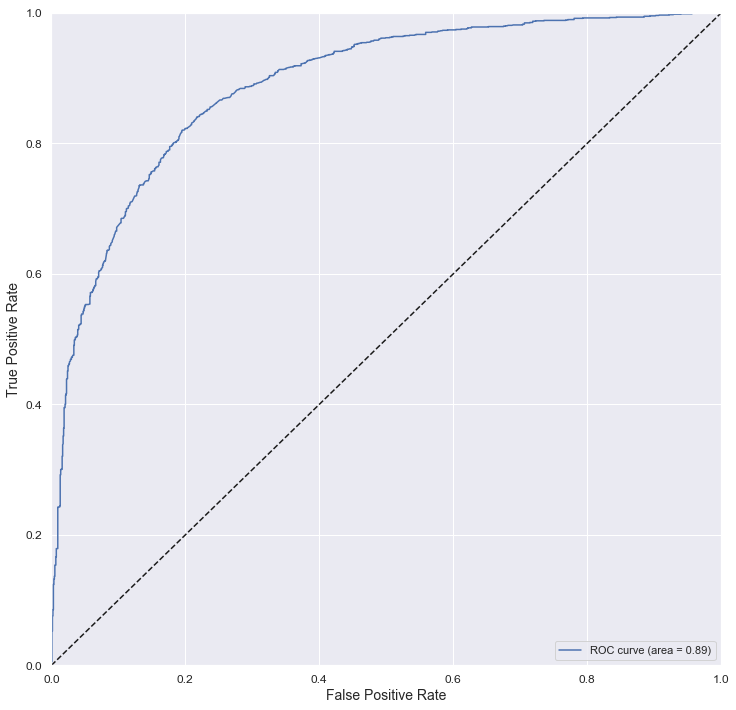

Accuracy_train:  0.8800		Accuracy_test:   0.8100
Precision_test:  0.8299		Recall_test:     0.8110
ROC-AUC_test:    0.8897		F1_test:         0.8203		MCC_test: 0.6190


In [59]:
#Initialize Model
cb_mdl = CatBoostClassifier(learning_rate=0.5, depth=7, random_seed=rand)

#Train Model
fitted_cb_mdl = cb_mdl.fit(X_train, y_train, verbose=False, plot=False)

#Evaluate Model
y_train_cb_pred, y_test_cb_prob, y_test_cb_pred =\
        evaluate_class_mdl(fitted_cb_mdl, X_train,\
                                      X_test, y_train, y_test)

From the optics of fairness, we care more about false positives than false negatives because it's more unfair to put an "innocent" person in prison than leaving a "guilty" person in the streets. Therefore, we should aspire to have higher _precision_ than _recall_. The above metrics confirm this, as well as a healthy ROC curve, ROC-AUC and Matthews Correlation Coefficient (MCC).

## 6) Global Intepretation Methods

### 6.1) Feature Importance

Many model classes come with built-in methods for calculating "feature importance" or their intrinsic parametres (weights, coefficients, etc) are inherently interpretable. These methods are **model-specific**.

In [185]:
fitted_cb_mdl.get_feature_importance(Pool(X_test, y_test), prettified=True)

Feature Id  Importances
0                     age    32.403065
1            priors_count    27.623525
2   race_African-American     4.745382
3              sex_Female     4.255161
4          race_Caucasian     4.149955
5    c_charge_degree_(M1)     3.883984
6    c_charge_degree_(F3)     3.859984
7         juv_other_count     3.354910
8          juv_misd_count     2.707041
9    c_charge_degree_(F2)     2.493552
10   c_charge_degree_(M2)     1.985211
11          race_Hispanic     1.979978
12          juv_fel_count     1.925253
13             race_Other     1.845372
14               sex_Male     1.399216
15  c_charge_degree_(MO3)     0.470127
16   c_charge_degree_(F1)     0.436828
17   c_charge_degree_(F7)     0.238822
18             race_Asian     0.113254
19  c_charge_degree_Other     0.072465
20   race_Native American     0.056914

### 6.2) SHAP (SHapley Additive exPlanations) — Model-Agnostic Method

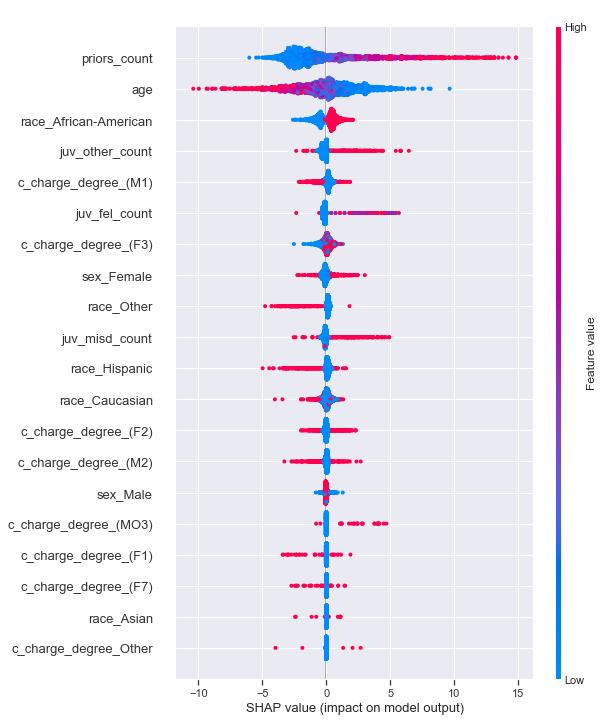

In [61]:
shap_vals = fitted_cb_mdl.get_feature_importance(Pool(X_test, y_test),\
                                                   type="ShapValues")[:,:-1]

#BTW: You can use SHAP as below to generate the SHAP Values but Catboost does it for you (as above):
#  shap_explainer = shap.TreeExplainer(fitted_cb_mdl)
#  shap_vals = shap_explainer.shap_values(X_test)
#BTW: If you prefer probabilities to be returned, this is how it's done but its more time consuming:
#  shap_explainer = shap.TreeExplainer(fitted_cb_mdl, feature_dependence="independent",\
#                                      model_output="probability", data=shap.kmeans(X_train, 10).data)
#  shap_vals = shap_explainer.shap_values(X_test)

shap.summary_plot(shap_vals, X_test, plot_type="dot", show=False)
fig = plt.gcf()
fig.set_size_inches(8,12)
plt.show()

### 6.3) PDP (Partial Dependence Plots) — Model-Agnostic Method

With **PDPBox**, let's produce PDPs for the top 4 most important features, according to SHAP. To that end, let's save their names (`feature_names`) and corresponding labels (`feature_labels`) in lists.

In [62]:
feature_names = ['priors_count', 'age', 'race_African-American', 'c_charge_degree_(F3)']
feature_labels = ['# Priors', 'Age', 'race: African American', 'charge degree: Felony 3rd Level']

Then, we iterate through the lists producing PDPs for each one.

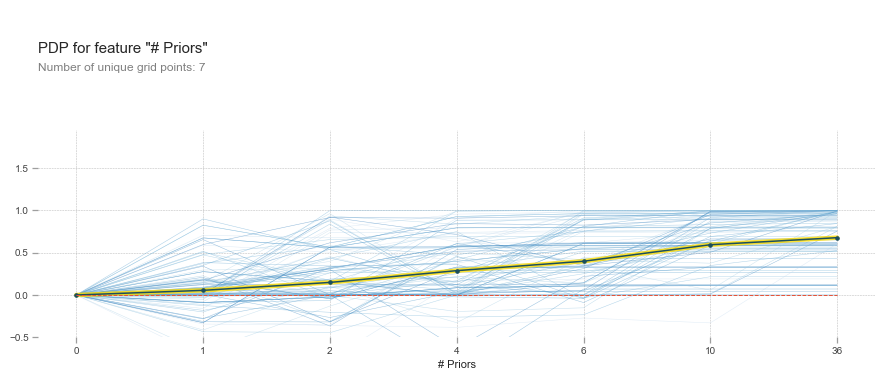

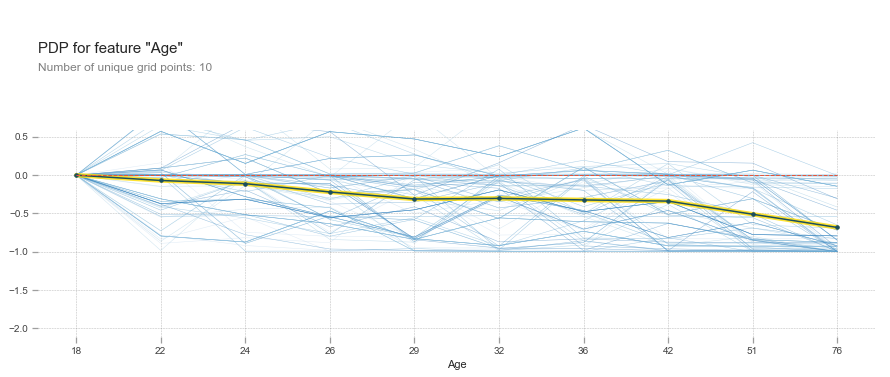

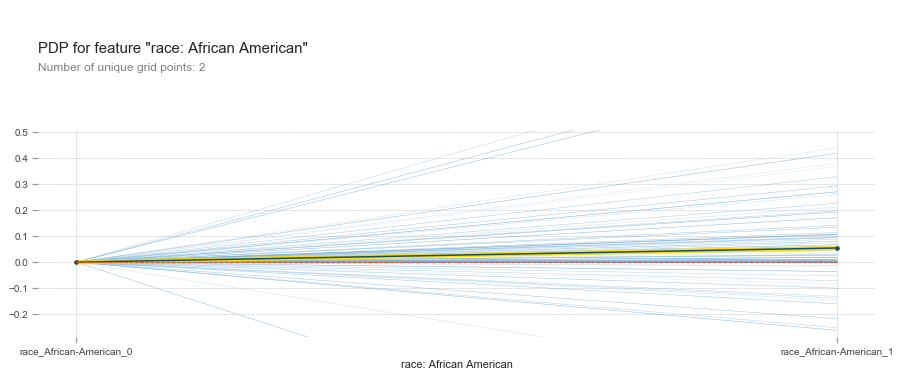

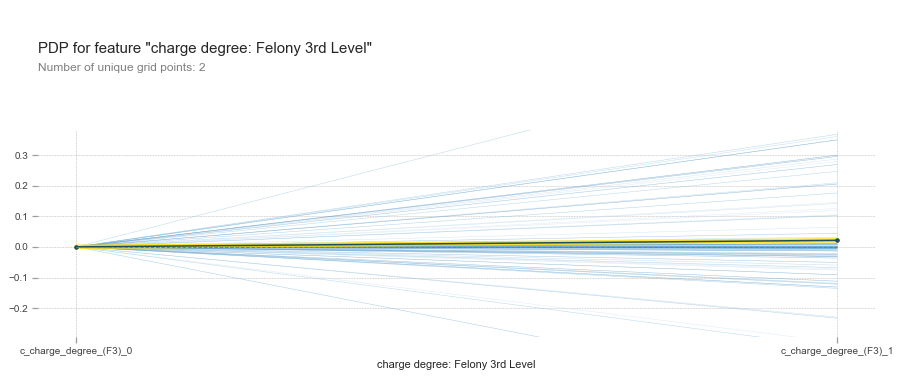

In [118]:
for i in range(len(feature_names)):
    #`pdp_isolate` computes PDP data to be plotted by `pdp_plot`.
    pdp_feat_df = pdp.pdp_isolate(\
        model=fitted_cb_mdl, dataset=pd.concat((X_test, y_test), axis=1),\
        model_features=X_test.columns, feature=feature_names[i]
    )
    #`pdp_plot` plots the partial dependence plot.
    fig, axes = pdp.pdp_plot(
        pdp_isolate_out=pdp_feat_df, center=True, x_quantile=True,\
        plot_lines=True, frac_to_plot=100, figsize=(15,6),\
        feature_name=feature_labels[i]
    )

### 6.4) Measuring Interactions

#### 6.4.1) Feature Importance for Interactions

In [199]:
#Create a dictionary that match index and column names.
col_idx_to_name = dict(zip(list(range(0, X_test.shape[1])),X_test.columns))

#Get feature importance for interaction of features and use dictionary to replace indexes with names.
#Output just the top 10 interactions.
fitted_cb_mdl.get_feature_importance(Pool(X_test, y_test), type='Interaction', prettified=True).\
            replace(col_idx_to_name).\
            rename(columns={'First Feature Index':'Feature 1', 'Second Feature Index':'Feature 2'}).head(10)

Feature 1              Feature 2  Interaction
0           age           priors_count    25.846184
1           age             sex_Female     3.822221
2           age  race_African-American     3.293857
3           age         race_Caucasian     3.055728
4           age        juv_other_count     2.954705
5           age   c_charge_degree_(M2)     2.737270
6           age   c_charge_degree_(M1)     2.530325
7  priors_count         race_Caucasian     2.502433
8  priors_count             sex_Female     2.430670
9           age   c_charge_degree_(F3)     2.414079

#### 6.4.2) Visualizing Interactions — Model-Agnostic Methods

**SHAP can produce dependence plots that use Shap Values with "Interaction Index"**

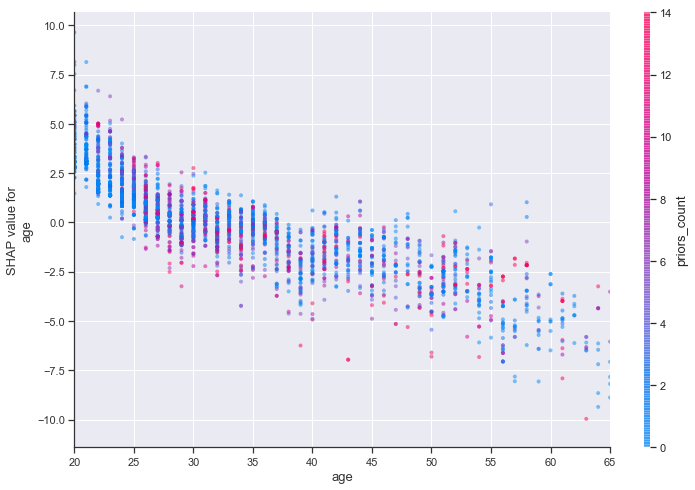

In [120]:
#Plot for `age` with interaction index for `priors_count` with `dependence_plot`. 
#We are using xmin and xmax to hide outliers and alpha of 50% to easily identify sparser areas.
shap.dependence_plot("age", shap_vals, X_test, interaction_index="priors_count",\
                     show=False, xmin="percentile(1)", xmax="percentile(99)", alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

**PDPBox can often produce interaction plots that are easier to understand**

Same as before except we iterate to xompare the most important feature with the following three most important. This time it uses different functions that take two features at a time.

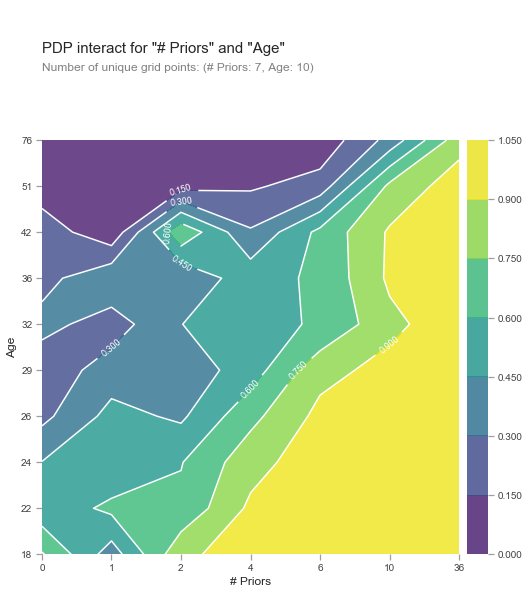

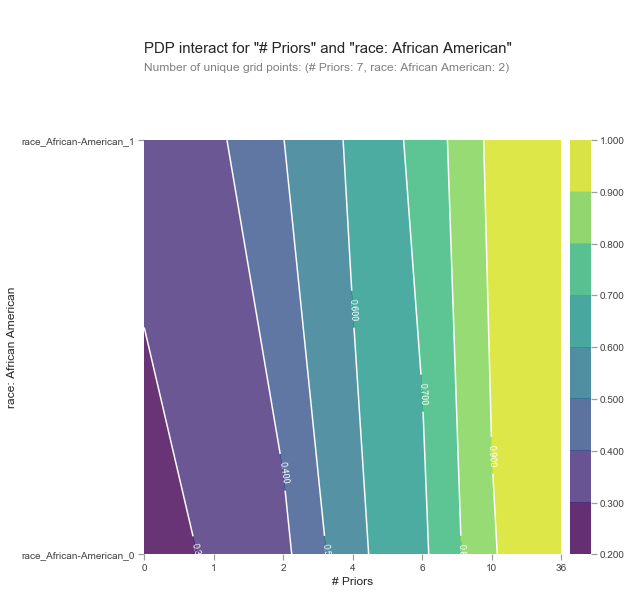

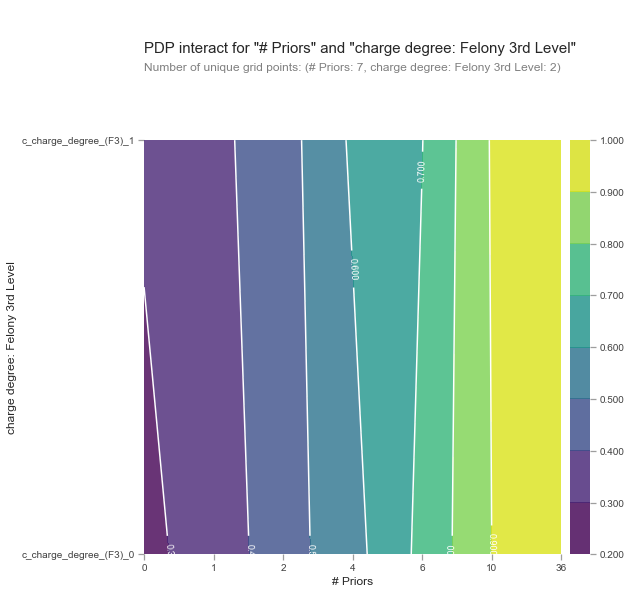

In [119]:
for i in range(1, len(feature_names)):
    #pdp_interact computes interactive PDP data to be plotted by pdp_interact_plot
    pdp_feats_df = pdp.pdp_interact(
        model=fitted_cb_mdl, dataset=pd.concat((X_test, y_test), axis=1), n_jobs=-1,\
        model_features=X_test.columns, features=[feature_names[0], feature_names[i]]
    )
    #pdp_plot plots the interactive partial dependence plot
    fig, axes = pdp.pdp_interact_plot(
        pdp_interact_out=pdp_feats_df, x_quantile=True, plot_type='contour',\
        figsize=(8,10), feature_names=[feature_labels[0], feature_labels[i]]
    )

## 7) Local Intepretation Methods

### 7.1) Examining our "Instance of Interest"

Let's assume we are asked to look into the case of an African-American male defendent with 2 priors and no juvenile offenses, his data point is our _instance of interest_. To compare, let's also take similar points, except one is Hispanic and another one is Caucasian.

In [156]:
similarity = (X_test.priors_count==2) & (X_test.juv_fel_count==0) & (X_test.juv_misd_count==0) &\
             (X_test.juv_other_count==0) & (X_test['sex_Male']==1)

#The index of an African-American Defendent (the instance of interest).
aa_idx = X_test[(X_test.age==23) & similarity & (X_test['race_African-American']==1) &\
                (X_test['c_charge_degree_(F7)']==1)].index[0]

#The index of two similar datapoints for and Hispanic and Caucasian defendents.
h_idx = X_test[(X_test.age==23) & similarity & (X_test['race_Hispanic']==1) &\
               (X_test['c_charge_degree_(F3)']==1)].index[0]
c_idx = X_test[(X_test.age==24) & similarity & (X_test['race_Caucasian']==1) &\
               (X_test['c_charge_degree_(M1)']==1)].index[0]

#Create boolean array to easily locate indexes in X_test dataframe.
instance_idxs = X_test.index.isin([aa_idx, h_idx, c_idx])

#Find instances in both X_test and recidivism2_df dataframes.
X_test_instances = X_test[instance_idxs]
X_instances = recidivism2_df[recidivism2_df.index.isin([aa_idx, h_idx, c_idx])]

#Create a dataframe joining y_test (the `compas_score` label), y_test_cb_pred (the predictions for Catboost),
# X_instances (to get `did_recid`) and X_test (for the rest of the features).
compare_df = pd.concat([\
            pd.DataFrame({'compas_score':y_test[instance_idxs]},\
                         index=[c_idx, h_idx, aa_idx]),\
            pd.DataFrame({'y_pred':y_test_cb_pred[instance_idxs]},\
                         index=[c_idx, h_idx, aa_idx]),\
            pd.DataFrame({'did_recid':np.array(X_instances['did_recid'])},\
                         index=[c_idx, h_idx, aa_idx]),\
            X_test_instances], axis=1).set_index([pd.Index(['Caucasian',\
                            'Hispanic', 'African-American'])]).transpose().\
            style.apply(lambda x: ['background: yellow' if (x[2] != x[1] or x[2] != x[0])\
            else '' for i in x], axis=1).apply(lambda x: ['background: lightgreen'\
            if (x.name == 'did_recid') else '' for i in x], axis=1)

compare_df

### 7.2) LIME — Model-Agnostic Method

**Initialize LIME Explainer for Tabular Data**

In [105]:
#Providing the names of the classes make for more readable explanations.
class_names = ['Low Risk', 'Medium/High Risk']

#Instatiate Lime Tabular explainer with the test data, class names, feature names and 
# indexes of categorical features.
lime_cb_explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, class_names=class_names,\
                        feature_names=X_test.columns, categorical_features=np.where(X.dtypes != np.int64)[0])

**Explain Instance for African-American Defendant**

In [115]:
#All LIME requires to explain an instance, is the data for the instance, the predict function and 
# how many features to limit the explanation to.
lime_cb_explainer.explain_instance(X_test.loc[aa_idx].values,\
                                    fitted_cb_mdl.predict_proba,\
                                    num_features=6).\
                                show_in_notebook(predict_proba=True)

**Explain Instance for Caucasian Defendant**

In [116]:
lime_cb_explainer.explain_instance(X_test.loc[c_idx].values,\
                                    fitted_cb_mdl.predict_proba,\
                                    num_features=6).\
                                show_in_notebook(predict_proba=True)

**Explain Instance for Hispanic Defendant**

In [117]:
lime_cb_explainer.explain_instance(X_test.loc[h_idx].values,\
                                    fitted_cb_mdl.predict_proba,\
                                    num_features=6).\
                                show_in_notebook(predict_proba=True)

### 7.3) Anchors Explanations — Model-Agnostic Method

**Initialize Anchor Explainer for Tabular Data**

In [95]:
#These are all the categorical features, and what their categories are called.
#Anchor uses this to make a human interpretable explanation.
category_map_ohe = {5: ['Not Female', 'Female'], 6: ['Not Male', 'Male'],\
        7:['Not African American', 'African American'],\
        8:['Not Asian', 'Asian'], 9:['Not Caucasian', 'Caucasian'],\
        10:['Not Hispanic', 'Hispanic'],\
        11:['Not Native American', 'Native American'],\
        12:['Not Other Race', 'Other Race'],\
        13:['Not Felony 1st Level', 'Felony 1st Level'],\
        14:['Not Felony 2nd Level', 'Felony 2nd Level'],\
        15:['Not Felony 3rd Level', 'Felony 3rd Level'],\
        16:['Not Felony 7th Level', 'Felony 7th Level'],\
        17:['Not Misdemeanor 1st Deg', 'Misdemeanor 1st Deg'],\
        18:['Not Misdemeanor 2nd Deg', 'Misdemeanor 2nd Deg'],\
        19:['Not Misdemeanor 3rd Deg', 'Misdemeanor 3rd Deg'],\
        20:['Not Other Charge Degree', 'Other Charge Degree']}

#All Anchor needs from the model is a predict function. 
#In this case, we use `predict_proba` and wrap it in a lambda function.
predict_cb_fn = lambda x: fitted_cb_mdl.predict_proba(x)

#Instantiating AnchorTabular only requires predict function, names of columns,
#and (optionally) category map. 
anchor_cb_explainer = AnchorTabular(predict_cb_fn, X_train.columns,\
                                    categorical_names=category_map_ohe)

#Then you fit the explainer it to the training data
anchor_cb_explainer.fit(X_train.values)

AnchorTabular(meta={
    'name': 'AnchorTabular',
    'type': ['blackbox'],
    'explanations': ['local'],
    'params': {'seed': None, 'disc_perc': (25, 50, 75)}
})

**Explain Instance for African-American Defendant**

In [99]:
#Provide the explainer an instance and a threshold, and it will generate
# an explanation.
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[aa_idx].values, threshold=0.85,\
                                seed=rand)

#Print the explanation:
print('Prediction: %s' %\
      class_names[anchor_cb_explainer.predictor(X_test.loc[aa_idx].values)[0]])
print('Anchors: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Prediction: Medium/High Risk
Anchor: age <= 25.00 AND
	priors_count > 0.00 AND
	race_African-American = African American
Precision: 0.900
Coverage: 0.290


Now, same as before but let's increase the threshold:

In [100]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[aa_idx].values, threshold=0.9,\
                                seed=rand)
print('Prediction: %s' %\
      class_names[anchor_cb_explainer.predictor(X_test.loc[aa_idx].values)[0]])
print('Anchors: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Prediction: Medium/High Risk
Anchor: age <= 25.00 AND
	priors_count > 0.00 AND
	race_African-American = African American AND
	c_charge_degree_(M1) = Not Misdemeanor 1st Deg AND
	c_charge_degree_(F3) = Not Felony 3rd Level
Precision: 0.905
Coverage: 0.290


**Explain Instance for Caucasian Defendant**

In [102]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[c_idx].values, threshold=0.85,\
                                seed=rand)
print('Prediction: %s' %\
      class_names[anchor_cb_explainer.predictor(X_test.loc[c_idx].values)[0]])
print('Anchors: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Prediction: Low Risk
Anchor: priors_count <= 2.00 AND
	race_African-American = Not African American AND
	c_charge_degree_(M1) = Misdemeanor 1st Deg
Precision: 0.892
Coverage: 0.578


**Explain Instance for Hispanic Defendant**

In [103]:
anchor_cb_explanation =\
    anchor_cb_explainer.explain(X_test.loc[h_idx].values, threshold=0.85,\
                                seed=rand)
print('Prediction: %s' %\
      class_names[anchor_cb_explainer.predictor(X_test.loc[h_idx].values)[0]])
print('Anchors: %s' % (' AND\r\n\t'.join(anchor_cb_explanation.anchor)))
print('Precision: %.3f' % anchor_cb_explanation.precision)
print('Coverage: %.3f' % anchor_cb_explanation.coverage)

Prediction: Low Risk
Anchor: priors_count <= 2.00 AND
	race_Hispanic = Hispanic AND
	juv_fel_count <= 0.00 AND
	race_African-American = Not African American
Precision: 0.856
Coverage: 0.957


### 7.4) Counterfactual Explanations with WIT (What-If-Tool) — Model-Agnostic Method

The following two function will help generate the dashboard configuration:

In [703]:
def custom_predict_with_shap(inputs_l, train_cols_idx, predict_fn, shap_vals, train_cols_l):
    """Return predictions and attributions dictionary for WIT dashboard.
    
    Keyword arguments:
    inputs_l -- input data (list)
    train_cols_idx -- index of columns used in training of model (list or array)
    predict_fn -- the prediction function for the model (function)
    shap_vals -- SHAP values for models features and observations (array)
    keepcols_l -- column names used in training of model (list or array)
    """
    
    #For predictions we need observations with same features
    # that were used for training.
    inputs_np = np.array(inputs_l)[:,train_cols_idx]

    #Get the model's class predictions.
    preds = predict_fn(inputs_np)

    if shap_vals is not False:
        #With test data generate SHAP values which converted
        # to a list of dictionaries format.
        attributions = []
        for shap in shap_vals:
            attrs = {}
            for i, col in enumerate(train_cols_l):
                attrs[col] = shap[i]
            attributions.append(attrs)

        #Prediction function must output 
        # predictions/attributions in dictionary.
        output = {'predictions': preds,\
                  'attributions': attributions}
    else:
        output = {'predictions': preds}
        
    return output

def create_wit_config_for_model(fitted_mdl, wit_df, train_cols_l, target, class_names, shap_vals=None):
    """Generate a WIT Configuration for model.
    
    Keyword arguments:
    fitted_mdl -- a fitted tree-based model (catboost, xgboost, lightgbm, scikit-learn)
    wit_df -- data you want to load in dashboard (pandas dataframe)
    keep_cols_l -- column names used in training of model (list or array)
    target -- the name of the column which is the target feature
    class_names -- the name of the classes (list or array)
    shap_vals -- SHAP values for models features and observations (array)
    """
    
    #The indexes of the columns used to train the model.
    train_cols_idx = np.where(wit_df.columns.isin(train_cols_l))[0]
    
    #WIT needs a predict function for the model.
    predict_fn = lambda x: fitted_mdl.predict_proba(x)
    
    #If not provided, generate SHAP values.
    if shap_vals is None:
        shap_explainer = shap.TreeExplainer(fitted_mdl)
        shap_vals = shap_explainer.shap_values(wit_df)

    #Used by the WIT Config Builder to call the custom predict function.
    custom_predict_with_shap_fn = lambda inputs_l: custom_predict_with_shap(inputs_l, train_cols_idx,\
                                                                            predict_fn, shap_vals,\
                                                                            train_cols_l)
    
    #WIT config needs the data as a list but first we convert to a NumPy array. 
    wit_np = wit_df.values

    #WIT config needs the names of all the columns.
    cols_l = wit_df.columns
    
    #Create the config with all the previously prepared elements.
    wit_config_builder = WitConfigBuilder(\
                        wit_np.tolist(), feature_names=cols_l.tolist()
                    ).set_custom_predict_fn(custom_predict_with_shap_fn).\
                    set_target_feature(target).set_label_vocab(class_names)

    return wit_config_builder

We will need the location of the index for our main instance of interest so we can locate it in the dashboard:

In [161]:
print(y_test.index.get_loc(aa_idx))

1566


Now, let's build the dashboard.

In [678]:
#All the dashboard widget requires is the configuration. Optionally, you can set a height (in pixels).  
WitWidget(create_wit_config_for_model(fitted_cb_mdl, recidivism2_df.loc[y_test.index],\
                                      X_train.columns.to_list(), "did_recid", class_names,\
                                      shap_vals), height=800)

WitWidget(config={'model_type': 'classification', 'label_vocab': ['Low Risk', 'Medium/High Risk'], 'feature_na…

## 8) Tuning for Interpretability

### 8.1) Feature Engineering for Interpretability

#### 8.1.1) Charge Degree: from categorical to ordinal

In [620]:
#First, let's make a copy of the dataframe to start over data preparation.
recidivism3_df = recidivism_df.copy()
#What categories did `c_charge_degree` originally have?
recidivism3_df.c_charge_degree.value_counts()

(F3)     8812
(M1)     3339
(F2)     1208
(M2)      991
(F1)      183
(F7)      123
(MO3)     103
(NI0)       8
(F5)        8
(CO3)       6
(F6)        5
(X)         1
(TCX)       1
Name: c_charge_degree, dtype: int64

Some are more severe than others. Let's give this column an order. **Might not make an impact performance wise but it will be more interpretable**.

In [621]:
charge_degree_code_rank = {'(F10)': 1, '(F9)':2, '(F8)':3, '(F7)':4, '(TCX)':4, '(F6)':5, '(F5)':6,\
                           '(F4)':7, '(F3)':8, '(F2)':9, '(F1)':10, '(M1)':11, '(NI0)':11, '(M2)':12,\
                           '(CO3)':12, '(MO3)':13, '(X)':14}
recidivism3_df['c_charge_degree'] = recidivism3_df.c_charge_degree.replace(charge_degree_code_rank)

#### 8.1.2) Age: from numeric to categorical (age groups)

In [622]:
recidivism3_df['age_groups'] = pd.qcut(recidivism3_df.age, 4).astype(str)
recidivism3_df.groupby(['age_groups'])['compas_score'].sum()/recidivism3_df['age_groups'].value_counts()

(17.999, 25.0]    0.682326
(25.0, 30.0]      0.580243
(30.0, 40.0]      0.483053
(40.0, 96.0]      0.329041
dtype: float64

The first two age groups correspond to what research says are **when most criminal activity and recidivism occurs**. 

#### 8.1.3) Priors Count: to interaction term

In [623]:
recidivism3_df['priors_per_year'] = round((recidivism3_df['priors_count']/(recidivism3_df['age'] - 17))*4,0)/4
recidivism3_df.groupby(['priors_per_year'])['did_recid'].sum()/recidivism3_df['priors_per_year'].value_counts()

0.00    0.320482
0.25    0.553464
0.50    0.661273
0.75    0.736739
1.00    0.792109
1.25    0.809160
1.50    0.869231
1.75    0.909091
2.00    0.409091
2.25    0.772727
2.50    0.962963
2.75    1.000000
3.00    1.000000
4.00    0.400000
4.25    0.000000
dtype: float64

**Recidivism rate tends to increase as priors per years increases** which is the justification for this new feature.

#### 8.1.4) Remove unecessary features

In [624]:
recidivism3_df.drop(['age', 'priors_count'], axis=1, inplace=True)

It is better to have broader age groups than individual ages because the model will get too detailed guided by gaps in the training data. Priors count is not needed anymore if the interaction term better represents the impact of priors in recidivism.

### 8.2) Mitigating Bias with XAI

#### 8.2.1) Measuring Imbalances

The imbalance of `race` is the one we most care about.

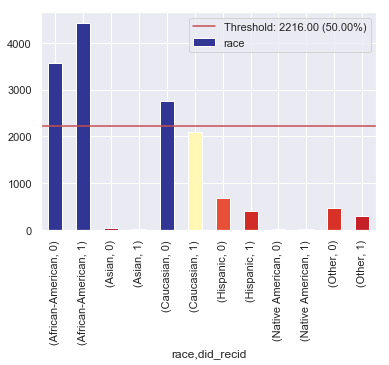

In [626]:
categorical_cols_l = ["race", "sex", "age_groups", "compas_score", "did_recid"]

xai.imbalance_plot(recidivism3_df, "race", "did_recid",\
                   categorical_cols=categorical_cols_l)

Besides `African-American` and `Caucasian`, all other races are entirely below the red line (in orange). 

#### 8.2.1) Adjusting for Imbalances

**Put lesser represented races in "Other" category**

The races that in previous chart were in orange can be bucketed as "Other" since it will be harder to balance the dataset by `race` accounting for them individually, and they don't really exhibit imbalance anyway.

In [627]:
recidivism3_df['race'] = np.where((recidivism3_df.race=='African-American') |\
                                  (recidivism3_df.race=='Caucasian'), recidivism3_df.race, 'Other')

**Plot imbalance again**

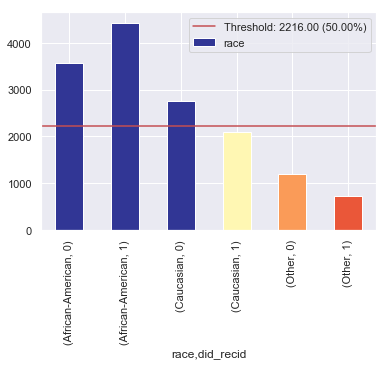

In [628]:
xai.imbalance_plot(recidivism3_df, "race", "did_recid",\
                   categorical_cols=categorical_cols_l)

All the blue bars should be downsampled to reach the red line, and all the rest are to be upsampled.

**Balance by `race`**

We could make all bars the same size by upsampling up to a higher amount. However, the "Other" `race` is not one third of the dataset and we wouldn't want the model to learn from so much upsampled data. Therefore, it's best to limit it to `0.27` which is where `(Other, 0)` and `(Other, 1)` match.

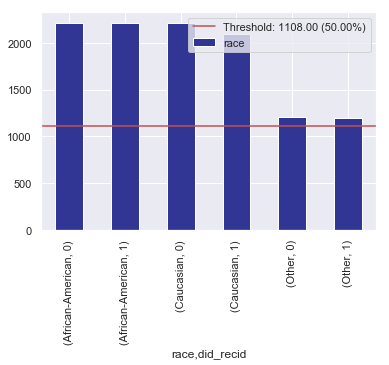

In [629]:
recidivism3_bal_df = xai.balance(recidivism3_df, "race", "did_recid",\
                                 categorical_cols=categorical_cols_l,\
               downsample=0.5, upsample=0.27)

**Check for `sex` imbalance**

This is often a consideration because you expect females and males to be evenly distributed in datasets. When broken down further by target variable you would also expect an even - and therefore fair - distribution. However, **women are far less likely to commit crimes and recidivate**. We will keep this imbalance noting that we could be much more rigurous here by making sure our data reflected the real-life recidivism rates.

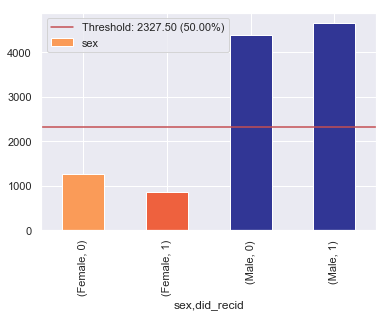

In [630]:
xai.imbalance_plot(recidivism3_bal_df, "sex", "did_recid",\
                   categorical_cols=categorical_cols_l)

#### 8.2.3) Check for correlations

XAI has some easy to use charts to plot correlations including `matrix` and the default, `dendogram`.

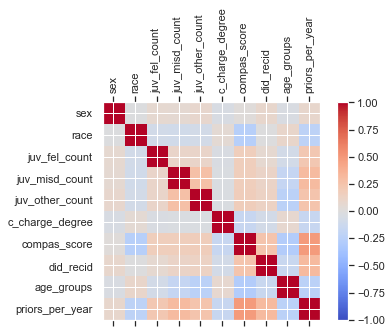

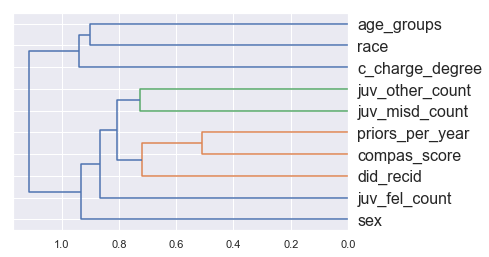

In [631]:
_ = xai.correlations(recidivism3_bal_df, include_categorical=True,\
                     plot_type="matrix")
_ = xai.correlations(recidivism3_bal_df, include_categorical=True)

### 8.3) Enforcing Monotonic Constraints and Cost-Sensitive Learning

#### 8.3.1) Train/Test Split Balanced Dataset

In [632]:
#Encode categorical columns.
categorical_cols_bal_l = ['sex', 'race', 'age_groups']
recidivism3_proc_df = xai.convert_categories(recidivism3_bal_df,\
                                            categorical_cols=categorical_cols_bal_l)

#Split into Train/Test (note that `balanced_train_test_split` is being used for good measure).
y_bal = recidivism3_proc_df['did_recid']
X_bal = recidivism3_proc_df.drop(['compas_score', 'did_recid'], axis=1).copy()
X_train_bal, y_train_bal, X_test_bal, y_test_bal, train_bal_idx, test_bal_idx =\
                        xai.balanced_train_test_split(X_bal, y_bal, "race",\
                                            categorical_cols=categorical_cols_bal_l,\
                                            min_per_group=444)

#Create dataframes with the balanced train and test data but prior to categorical encoding.
X_train_display = recidivism3_bal_df[train_bal_idx]
X_test_display = recidivism3_bal_df[test_bal_idx]

#Create dataframe with entire test data including labels.
test_df = X_test_display.copy()
test_df["did_recid"] = y_test_bal

#### 8.3.2) Deciding on Monotonic Constraints

Compute Spearman's rank correlation coefficient between each feature and the target (`did_recid`). When positive correlation is greater than 0.5, **assign a monotonic constraint of 1**. When correlation is negative and below -0.5, **assign a monotonic constraint of -1**. Otherwise 0.

In [633]:
#Output dataframe with features and the spearman correlation value for `did_recid`.
pd.DataFrame({'feature': X_bal.columns,\
              'correlation_to_target': np.delete(scipy.stats.spearmanr(recidivism3_bal_df.drop(['did_recid'], axis=1)).correlation[6],6)\
             }).style.background_gradient(cmap='plasma')

Only `only_priors_per_year` can be monotonic. It's not quite above `0.5` but almost there.

In [634]:
mono_con = [0, 0, 0, 0, 0, 0, 0, 1]

#### 8.3.2) Deciding on Weight for Cost-Sensitive Learning

Negative and positive classes are already fairly balanced. If they weren't you'd use something close to the number below.

In [635]:
print(y_train_bal[y_train_bal==0].shape[0]/y_train_bal[y_train_bal==1].shape[0])

1.0306586826347306


However, since we'd like to penalize False Positives, we can take a number smaller than `1.08`. Let's use `0.8`. While we are at it, let's also save the indexes of all categorical features since **CatBoost has a special way of handling categoricals** to make for a model that is not biased either in favor or against them.

In [636]:
scale_pos_weight = 0.8
categorical_cols_bal_idx = np.where(X_bal.dtypes == np.int8)[0]

#### 8.3.3) Training Monotonic Model on Balanced Dataset

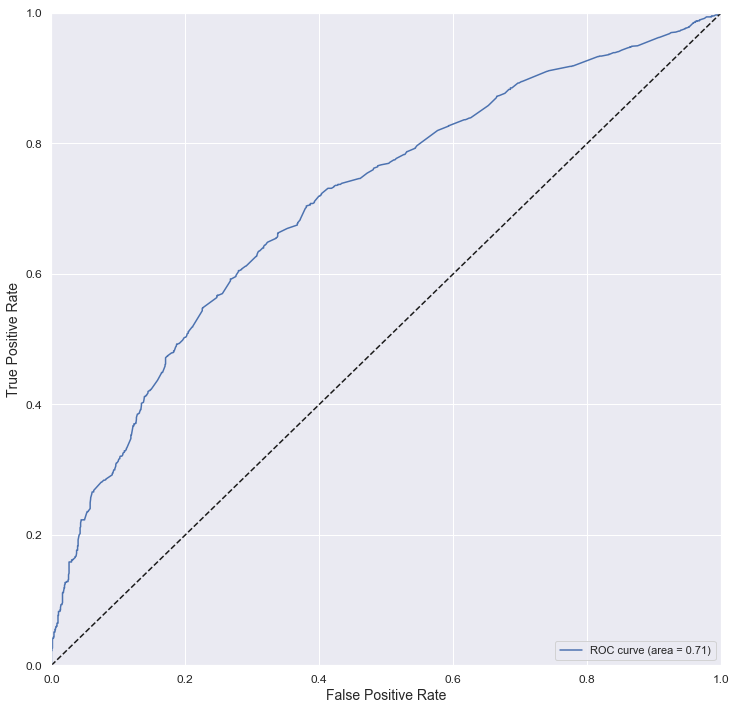

	Accuracy_train:  0.6720		Accuracy_test:   0.6607
	Precision_test:  0.7082		Recall_test:     0.5465
	ROC-AUC_test:    0.7100		F1_test:         0.6169		MCC_test: 0.3300


In [637]:
#Initialize Model
cb_mono_mdl = CatBoostClassifier(learning_rate=0.5, depth=9, monotone_constraints=mono_con,\
                                 scale_pos_weight=scale_pos_weight, cat_features=categorical_cols_bal_idx,\
                                 random_seed=rand)

#Train Model
fitted_cb_mono_mdl = cb_mono_mdl.fit(X_train_bal, y_train_bal, verbose=False, plot=False)

#Evaluate Model
y_train_mono_cb_pred, y_test_mono_cb_prob, y_test_mono_cb_pred =\
        evaluate_class_mdl(fitted_cb_mono_mdl, X_train_bal,\
                                      X_test_bal, y_train_bal, y_test_bal)

Predictive performance is not as good as previous model, but remember that this model is not a proxy model anymore but trained as ground truth (`did_recid`) as the target. When compared to COMPAS, accuracy actually was better. In any case, we are more interested in fairness.

### 8.4) Assessing Fairness with Confusion Matrices and XAI

#### 8.4.1) Comparing Confusion Matrices for Monotonic Model

We use the same code we used _3.3.2)_ but adapted for the monotonic models results.

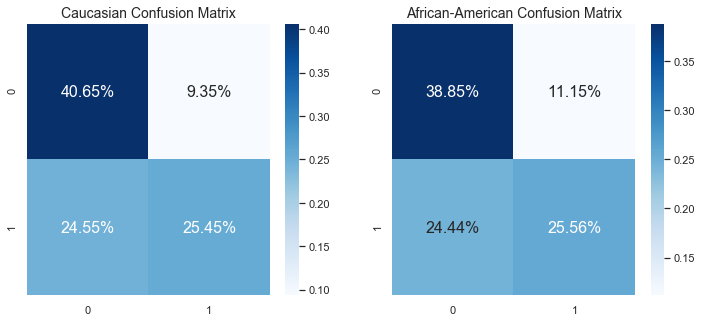

	African-American FPR:	22.3%
	Caucasian FPR:		18.7%
	Ratio FPRs:		1.19 x


In [638]:
_ = compare_confusion_matrices(y_test_bal[X_test_bal.race==1],\
                               y_test_mono_cb_pred[X_test_bal.race==1],\
                               y_test_bal[X_test_bal.race==0],\
                               y_test_mono_cb_pred[X_test_bal.race==0], 'Caucasian', 'African-American')

#### 8.4.2) Evaluating Fairness of Monotonic Model with XAI

**For Predictive Performance Metrics**

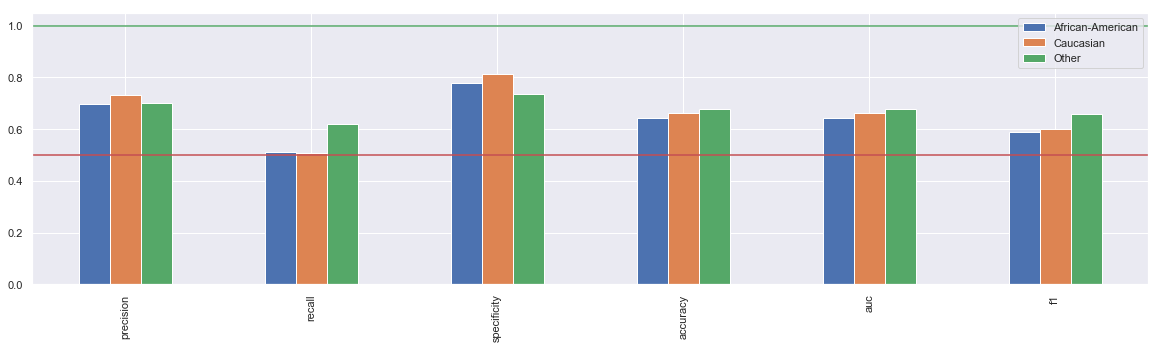

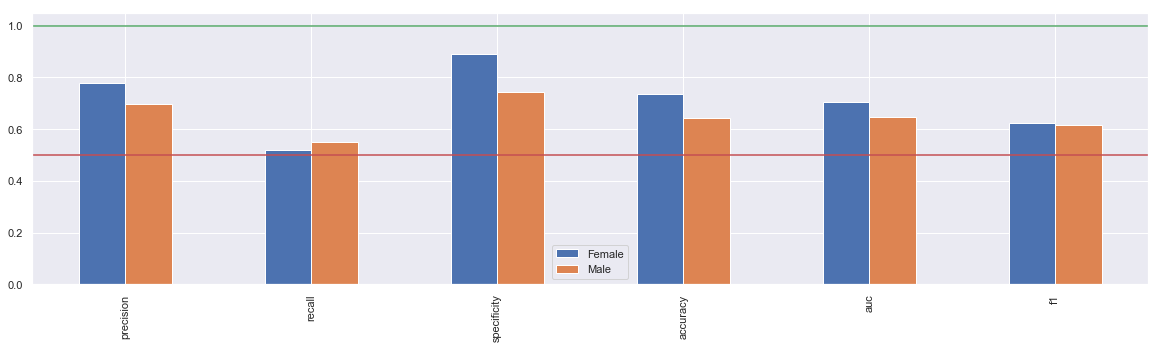

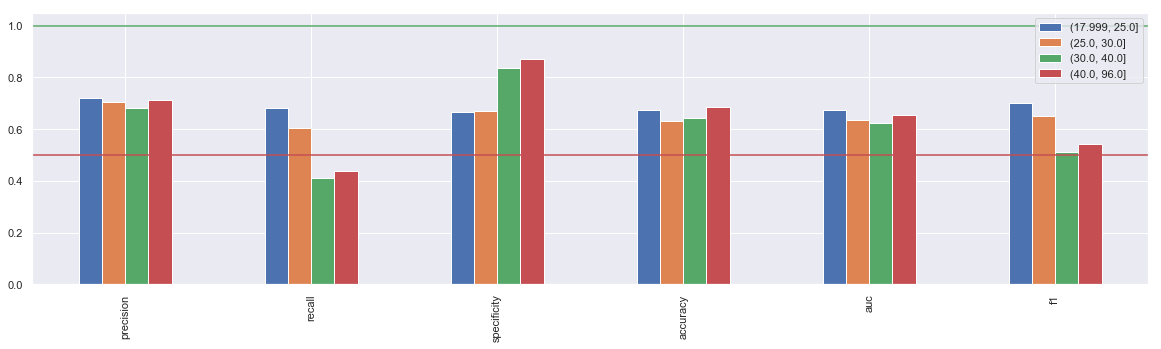

In [645]:
protected_cols_l = ["race", "sex", "age_groups"]
for p in protected_cols_l:
    _ = xai.metrics_plot(
        y_test_bal, 
        y_test_mono_cb_prob, 
        df=test_df, 
        cross_cols=[p],
        categorical_cols=categorical_cols_bal_l)

**For ROC Curves**

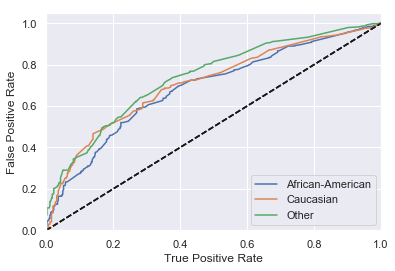

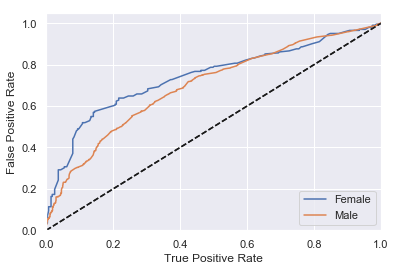

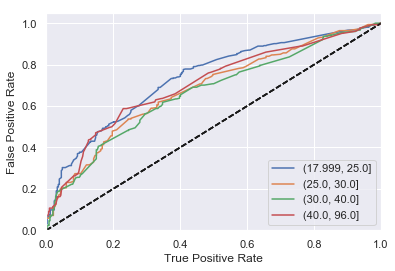

In [646]:
for p in protected_cols_l:
    _ = xai.roc_plot(
        y_test_bal, 
        y_test_mono_cb_prob, 
        df=test_df, 
        cross_cols=[p],
        categorical_cols=categorical_cols_bal_l)

**For Precision-Recall Curve**

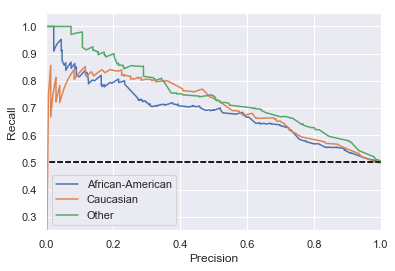

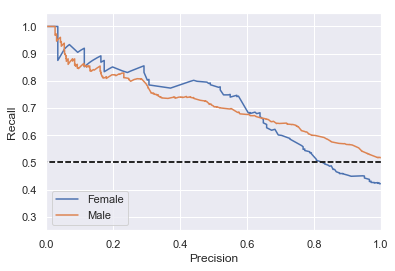

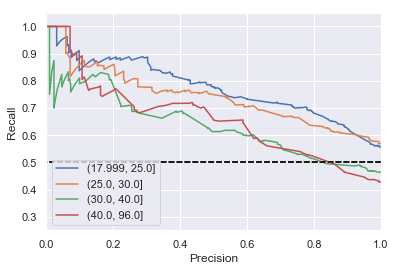

In [647]:
for p in protected_cols_l:
    _ = xai.pr_plot(
        y_test_bal, 
        y_test_mono_cb_prob, 
        df=test_df, 
        cross_cols=[p],
        categorical_cols=categorical_cols_bal_l)